# Лабораторная работа 2

Выполнил: Прокофьев А.Р. 301

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import folium


# Загрузка данных
В этом блоке мы загружаем тренировочный и тестовый наборы данных из CSV файлов.


In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Определение функции для вычисления манхэттенского расстояния
Манхэттенское расстояние рассчитывается как сумма абсолютных разностей координат.


In [4]:
def calculate_manhattan_distance(row):
    return (abs(row['pickup_longitude'] - row['dropoff_longitude']) +
            abs(row['pickup_latitude'] - row['dropoff_latitude']))

train_data['manhattan_distance'] = train_data.apply(calculate_manhattan_distance, axis=1)
test_data['manhattan_distance'] = test_data.apply(calculate_manhattan_distance, axis=1)


# Визуализация данных на карте

In [6]:
# Создание карты Нью-Йорка
ny_map = folium.Map(location=[40.730610, -73.935242], zoom_start=11)

for idx, record in train_data.sample(1000).iterrows():  # Отображаем случайные 1000 поездок
    folium.CircleMarker(
        [record['pickup_latitude'], record['pickup_longitude']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
    ).add_to(ny_map)

ny_map.save('ny_taxi_map.html')  # Сохраняем карту для дальнейшего анализа


# Удаление выбросов
В этом блоке мы убираем выбросы по времени поездки и количеству пассажиров.


In [5]:
train_data = train_data[(train_data['trip_duration'] > 60) & (train_data['trip_duration'] < 7200)]  # поездки от 1 мин до 2 часов
train_data = train_data[(train_data['passenger_count'] > 0) & (train_data['passenger_count'] <= 6)]


Добавляем новые признаки, такие как час и день недели, а также определяем часы пик.


In [7]:
# Преобразование временных меток
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])
train_data['hour'] = train_data['pickup_datetime'].dt.hour
train_data['day_of_week'] = train_data['pickup_datetime'].dt.dayofweek

test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'])
test_data['hour'] = test_data['pickup_datetime'].dt.hour
test_data['day_of_week'] = test_data['pickup_datetime'].dt.dayofweek

# Определение часов пик
train_data['is_rush_hour'] = train_data['hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 18) else 0)
test_data['is_rush_hour'] = test_data['hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 18) else 0)


Выбираем необходимые признаки для обучения модели


In [8]:
features_list = ['vendor_id', 'passenger_count', 'manhattan_distance', 'hour', 'day_of_week', 'is_rush_hour']

X_train_data = train_data[features_list]
y_train_data = train_data['trip_duration']

X_test_data = test_data[features_list]


Масштабируем данные для улучшения работы модели.


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_data)
X_test_scaled = scaler.transform(X_test_data)


Делим данные на обучающую и валидационную выборки для оценки качества модели.


In [11]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train_data, test_size=0.2, random_state=42)


Используем модель Ridge для предсказания продолжительности поездки.


In [12]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_split, y_train_split)


Ridge()

Проверяем качество модели на валидационных данных.


In [13]:
y_val_pred = ridge_model.predict(X_val_split)


Используем обученную модель для предсказания продолжительности поездок в тестовом наборе.


In [14]:
# Предсказания для тестового набора
test_data['trip_duration'] = ridge_model.predict(X_test_scaled)

# Подготовка данных для отправки
submission_data = test_data[['id', 'trip_duration']]
submission_data.to_csv('submission.csv', index=False)



Строим гистограмму для визуализации распределения предсказанных значений продолжительности поездки.


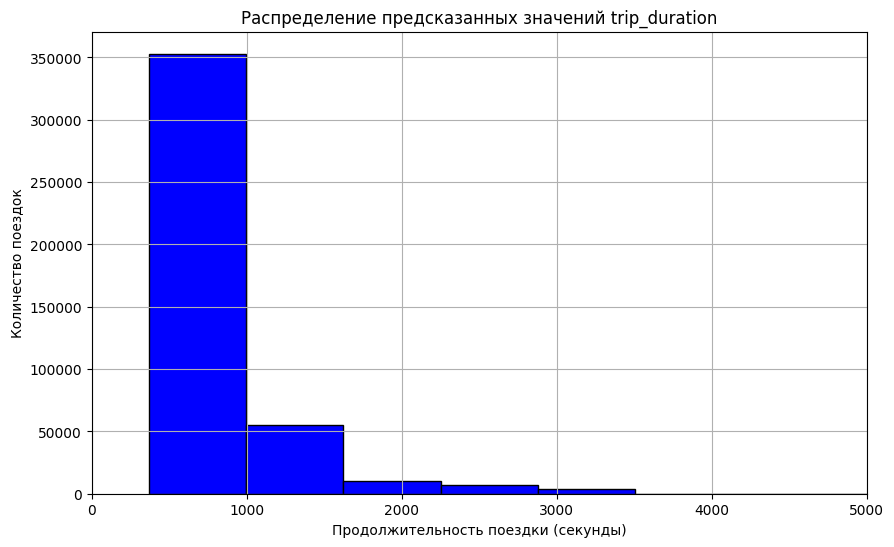

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(test_data['trip_duration'], bins=100, color='blue', edgecolor='black')
plt.title('Распределение предсказанных значений trip_duration')
plt.xlabel('Продолжительность поездки (секунды)')
plt.ylabel('Количество поездок')
plt.xlim(0, 5000)
plt.grid(True)
plt.show()


В этой лабораторной работе мы обработали данные о поездках на такси в Нью-Йорке, вычислили манхэттенское расстояние, удалили выбросы, извлекли временные признаки и обучили модель для предсказания продолжительности поездки. Результаты были визуализированы для лучшего понимания распределения предсказанных значений.
